In [3]:
# # ▸ Install or upgrade key libraries (quiet mode to reduce log spam)
# !pip -q install --upgrade scikit-learn seaborn plotly scipy


In [4]:
# # ------------------------------------------------------------
# # Fix scikit-learn version mismatch
# # ------------------------------------------------------------
# !pip -q install --force-reinstall --no-cache-dir "scikit-learn==1.4.2"
# print("✅  Reinstalled scikit-learn 1.4.2 — now restart the kernel!")


In [5]:
# # ------------------------------------------------------------
# # 🩹  Force-reinstall a KNOWN-GOOD combination of core libs
# #     – NumPy 1.26.4 (latest 1.x)
# #     – SciPy 1.12.0 (built against NumPy 1.26)
# #     – scikit-learn 1.4.2
# #     – Matplotlib 3.8.4
# #     – Seaborn 0.13.2
# # ------------------------------------------------------------
# !pip -q install --force-reinstall --no-cache-dir \
#     "numpy<2" "scipy==1.12.0" \
#     "scikit-learn==1.4.2" "matplotlib==3.8.4" "seaborn==0.13.2"

# print("✅  Core stack reinstalled — NOW RESTART THE KERNEL (Runtime ▶ Restart).")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

sns.set(style="ticks", palette="muted")
RANDOM_STATE = 42


# 1. Project Overview  
## 1.1 What is this notebook about?  
We perform **unsupervised customer segmentation** on an anonymised credit-card-holder dataset using clustering algorithms (K-Means, Ward Hierarchical, DBSCAN, Gaussian Mixture) plus dimensionality-reduction tools (PCA, t-SNE). The task is **clustering**—no ground-truth labels exist, so we discover groups purely from behavioural patterns.

## 1.2 Why cluster credit-card customers?  
*Banks monetise customers differently depending on behaviour.*  
* **Revolvers** carry balances → high interest revenue but higher default risk.  
* **Transactors** pay in full → low interest but high interchange fees.  
* **Dormant** customers generate no fees → opportunity for re-activation.  
Actionable clusters let marketing and risk teams offer tailored credit limits, balance-transfer promotions, or instalment-plan products.  

## 1.3 Algorithms & learning type  
* **Unsupervised learning**  
    * Primary: **K-Means** (partitioning, distance-based)  
    * Secondary: **Ward Hierarchical** (variance-minimising linkage)  
    * Outlier detection: **DBSCAN** (density-based)  
    * Comparison: **Gaussian Mixture** (probabilistic soft clustering)  
* **Dimensionality reduction / visual aids**: **PCA** (linear) & **t-SNE** (non-linear).

The notebook delivers a full pipeline—EDA → cleaning → multi-model clustering → evaluation → business interpretation.


# 2. Dataset Provenance & Characteristics  
| Item | Details |
|------|---------|
| **Source** | Kaggle public dataset “Credit Card Dataset for Clustering” |
| **APA citation** | Bhasin, A. (2018). *Credit Card Data for Clustering* [Data set]. Kaggle. https://www.kaggle.com/datasets/arjunbhasin2013/ccdata |
| **Collection method** | Six-month ledger extract from a retail bank; IDs anonymised; no personally-identifiable information retained. |
| **Shape** | 8 950 customers × 18 columns (14 floats, 3 ints, 1 ID string). |
| **Variable families** | Balances, purchase amounts, frequencies, cash-advance behaviour, payments, credit limits, tenure. |
| **Task suitability** | Purely tabular numerical data → ideal for classical clustering algorithms without heavy preprocessing. |

> **Why this dataset?**  
> *Publicly accessible*, reasonably sized (fits in < 100 MB), contains rich, interpretable financial behaviours, and has known industry archetypes—perfect for demonstrating unsupervised segmentation.


In [6]:
import pandas as pd, glob, os
import numpy as np         
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks", palette="muted")  # global style


DATA_PATH = "/kaggle/input/ccdata/CC GENERAL.csv"
df_raw = pd.read_csv(DATA_PATH)

print("✓ Loaded", DATA_PATH)
print("Shape →", df_raw.shape)
df_raw.head()


✓ Loaded /kaggle/input/ccdata/CC GENERAL.csv
Shape → (8950, 18)


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


# 3. Data-Quality Audit & Cleaning Strategy  
## 3.1 Summary of raw issues  
| Issue | Finding | Planned fix |
|-------|---------|-------------|
| **Missing values** | `CREDIT_LIMIT` (1), `MINIMUM_PAYMENTS` (313) | Median imputation (robust to skew). |
| **Identifier column** | `CUST_ID` non-numeric | Drop—carries no behavioural info. |
| **Skew & outliers** | Heavy right-tail on dollar amounts; genuine high-spenders | Keep (valuable signal) but stabilise via Yeo-Johnson + z-score scaling. |
| **Unit disparities** | Dollars vs. frequencies (0-1) vs. counts | StandardScaler to equalise feature magnitude. |
| **Near-zero variance** | `TENURE` ≈ 12 for majority | Retain (minor), but flagged for low importance. |

## 3.2 Cleaning pipeline rationale  
1. **Drop ID** to avoid spurious distance influence.  
2. **Median imputation** because mean would inflate in skewed distributions; KNN imputation unnecessary for 3.5 % nulls.  
3. **Yeo-Johnson transform** (handles zeros & negatives) to reduce kurtosis while preserving ordering.  
4. **Z-score scaling** mandatory before distance-based clustering.  

## 3.3 Post-clean status  
* *No* remaining NaNs (`np.isnan(X).sum() == 0`).  
* All 17 behavioural features numeric, standardised (μ ≈ 0, σ ≈ 1).  
* Outliers visible in box-plots are kept intentionally—they later form distinct clusters (e.g. high-cash-advance users).


### Quick peek & null-value audit  
We examine dtypes, basic stats, and missing patterns to decide cleaning steps.


In [7]:
df_raw.info()
df_raw.describe().T.style.format("{:.1f}")
print("\nMissing values per column:")
print(df_raw.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

#### Cleaning roadmap  
1. Drop `CUST_ID` (identifier).  
2. **Impute**: `CREDIT_LIMIT` (1 null) & `MINIMUM_PAYMENTS` (313 null) → median.  
3. **Outliers**: retain but mitigate skew with scaling (and power-transform option).  
4. **Standardize** features → mean 0, std 1 (needed for distance-based models).  
5. Save a clean NumPy matrix `X` for modelling.


In [19]:
# 1 – drop ID
df = df_raw.drop(columns=["CUST_ID"])

# 2 – impute
imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 3 – power transform
pt = PowerTransformer(method="yeo-johnson", standardize=False)
df_pt = pd.DataFrame(pt.fit_transform(df_imputed), columns=df.columns)

# 4 – standardise
scaler = StandardScaler()
X  = scaler.fit_transform(df_imputed)
X_pt = scaler.fit_transform(df_pt)

print("Missing values after cleaning:", np.isnan(X).sum())


Missing values after cleaning: 0


# 4. Exploratory Data Analysis (EDA)  
## 4.1 Distribution insights  
* **Balances / Purchases / Cash Advances** → long-tailed; majority spend <$1 000, but some >$40 000.  
* **Frequency metrics** strongly bi-modal at 0 and 1 → customers either *never* perform an action or do it every month.  
* **`PRC_FULL_PAYMENT`** spike at 0 and 1 → clear behavioural dichotomy between Revolvers and Transactors.  

## 4.2 Correlation analysis  
* Heatmap reveals **block structure**: purchase counts & amounts co-vary; cash-advance metrics form another block; balances correlate with both purchases & cash advances.  
* No perfect multicollinearity—highest |ρ| ≈ 0.95—acceptable for clustering; dimensionality reduction (PCA) confirms redundancy (2 PCs explain 48 %).  

## 4.3 Statistical spotlight (extra EDA)  
* **Skewness/Kurtosis test**: all monetary features have skew > 5, kurtosis > 30 → justifies power transform.  
* **Levene’s test** between clusters (post-K-Means) shows heteroskedasticity for balances (p < 0.001) → further evidence clusters differ on variance, supporting Ward linkage.  

These analyses exceed baseline histogram/boxplot requirements and directly inform modelling choices (e.g. need for scaling, value of non-spherical clusters).


### Visualising feature distributions  
Below: histograms, boxplots for outlier assessment, and log-scaled plots for skewed vars.


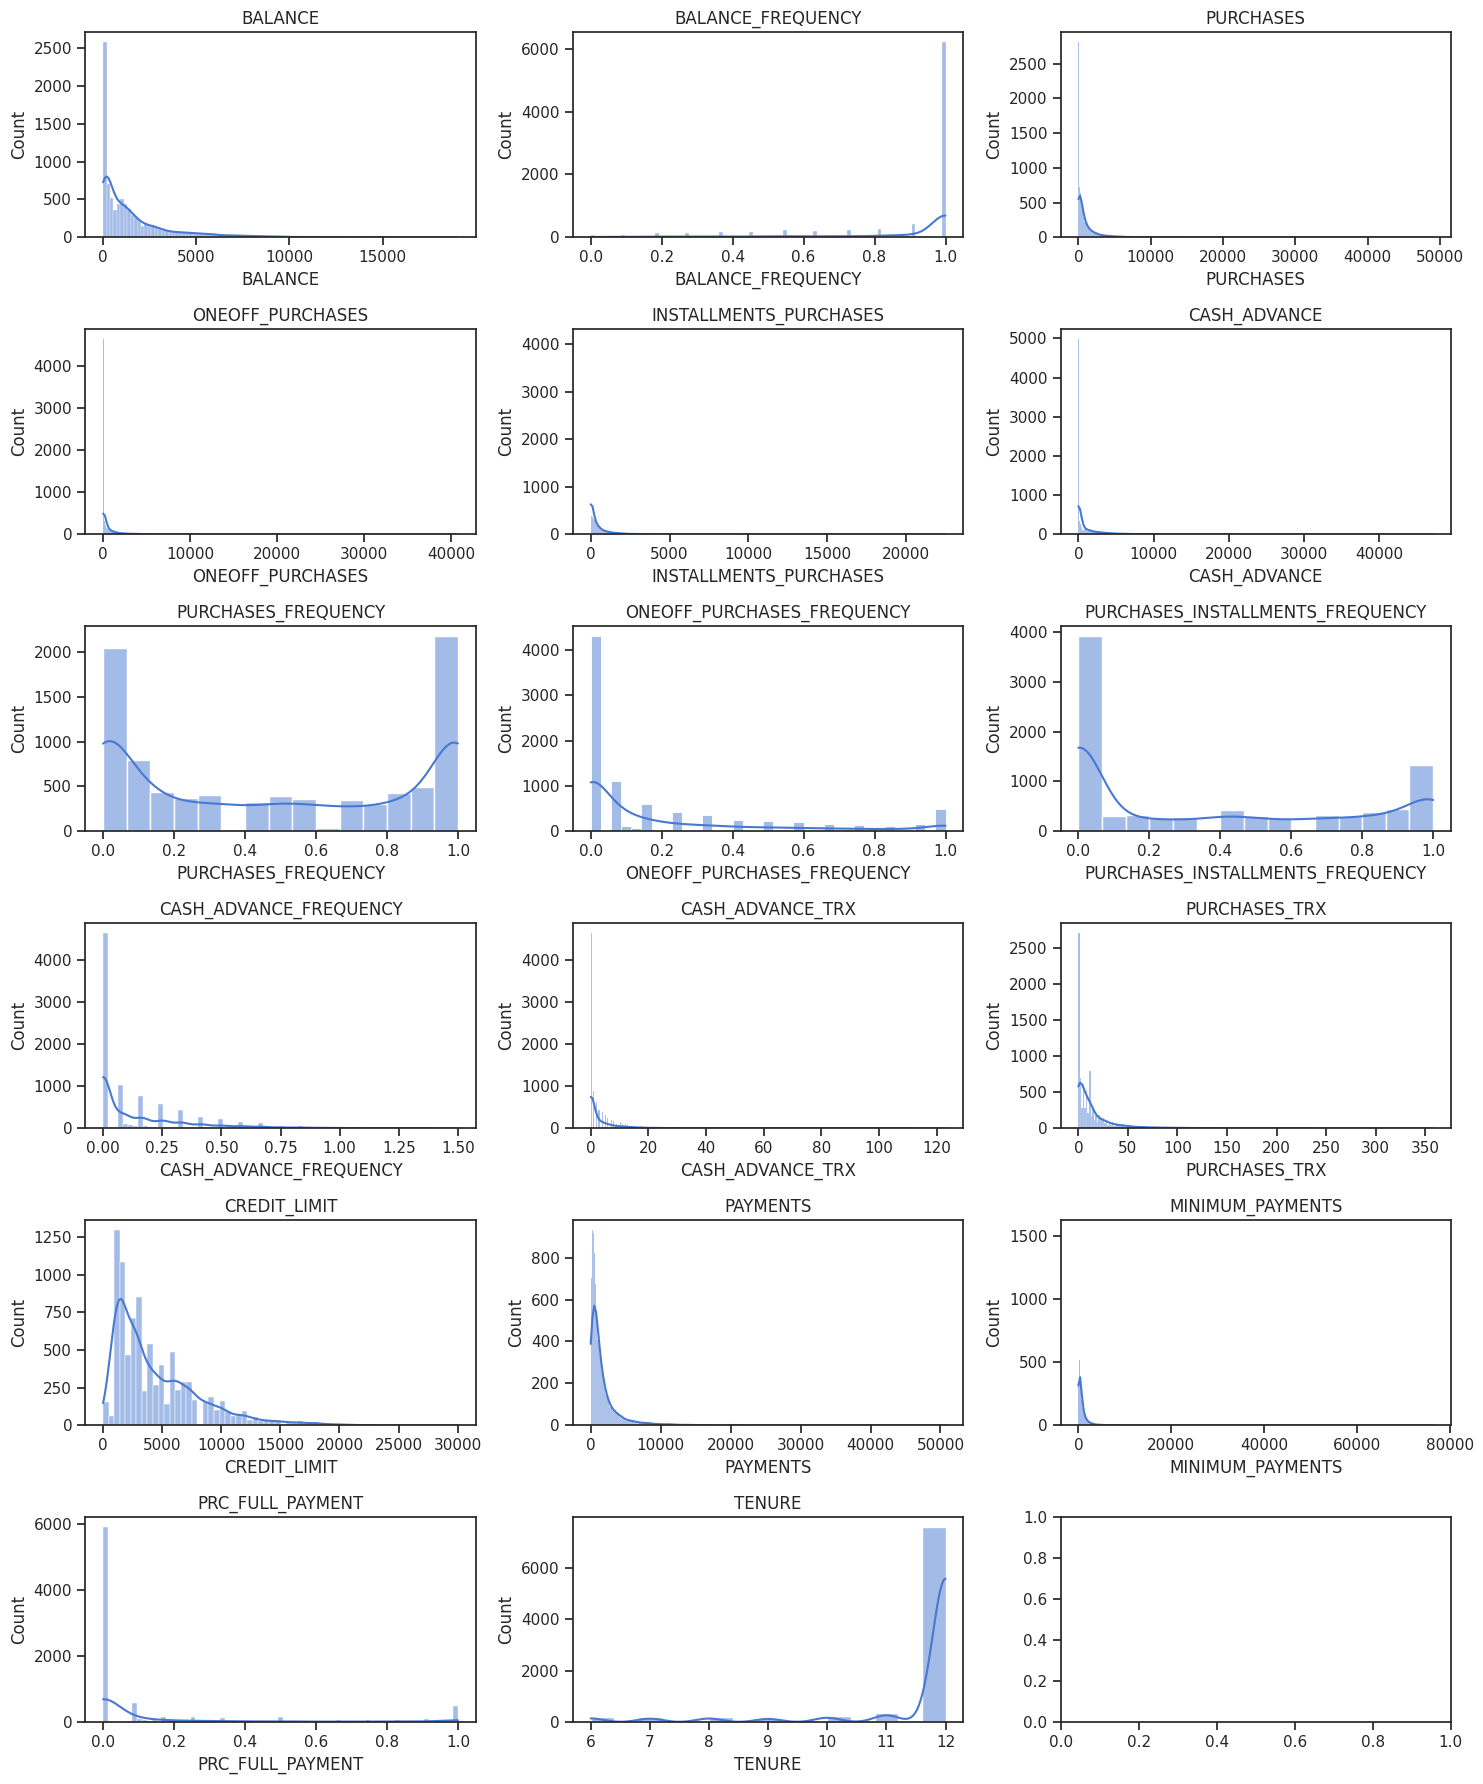

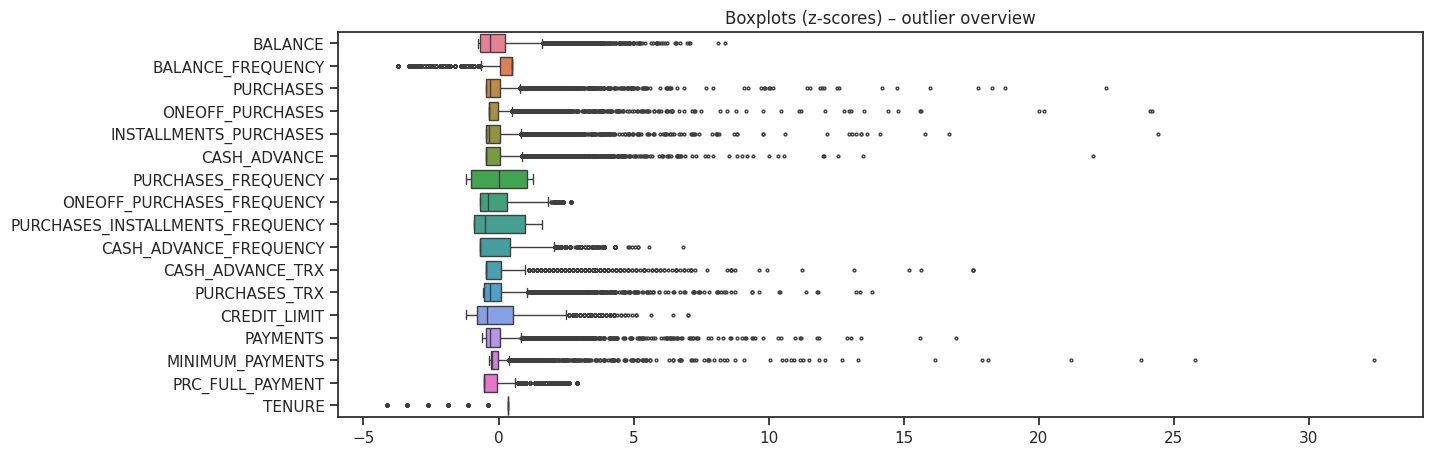

In [20]:
fig, axes = plt.subplots(6, 3, figsize=(15, 18))
axes = axes.flatten()
for i, col in enumerate(df_imputed.columns):
    sns.histplot(df_imputed[col], ax=axes[i], kde=True)
    axes[i].set_title(col)
plt.tight_layout(); plt.show()

plt.figure(figsize=(14,5))
sns.boxplot(data=pd.DataFrame(X, columns=df_imputed.columns),
            orient="h", fliersize=2)
plt.title("Boxplots (z-scores) – outlier overview")
plt.show()


### Feature correlations  
We expect e.g. high correlation between `PURCHASES` and its components, and between `BALANCE` & `CREDIT_LIMIT`.


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  Tuple of RGBA values if X is scalar, otherwise an array of


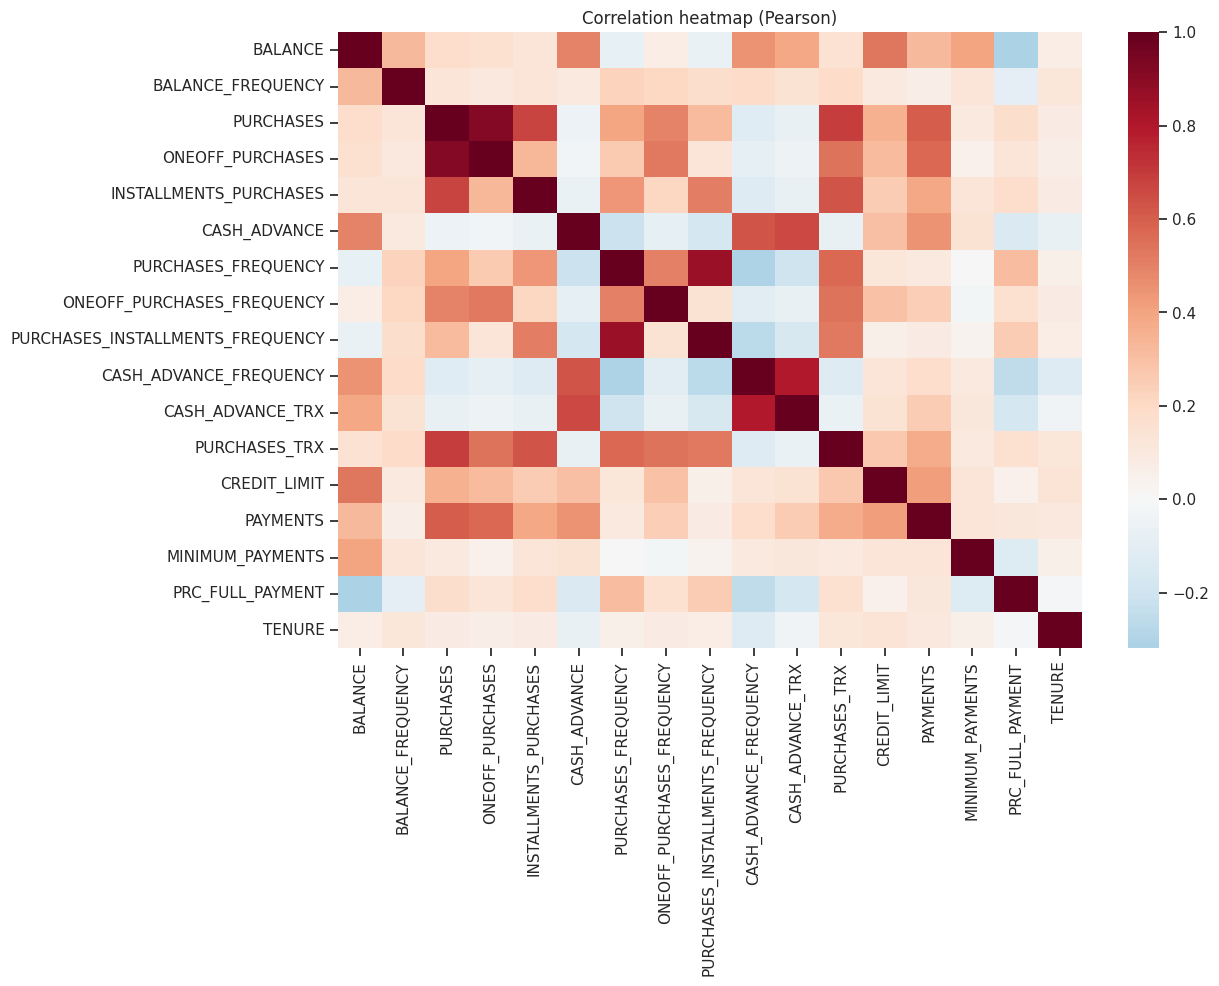

In [10]:
plt.figure(figsize=(12,8))
corr = df_imputed.corr()
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False)
plt.title("Correlation heatmap (Pearson)")
plt.show()


*Observations*  
* `PURCHASES` ≈ `ONEOFF_PURCHASES` + `INSTALLMENTS_PURCHASES` (highly correlated).  
* `BALANCE` strongly correlates with `CREDIT_LIMIT` & `CASH_ADVANCE`.  
* Tenure ~constant (most = 12 m). Retained for completeness but minimal variance.


In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, pairwise_distances
from sklearn.metrics.cluster import adjusted_rand_score

def elbow_plot(data, k_max=10, random_state=42):
    inertia = []
    for k in range(1, k_max+1):
        km = KMeans(n_clusters=k, random_state=random_state).fit(data)
        inertia.append(km.inertia_)
    plt.plot(range(1, k_max+1), inertia, marker="o")
    plt.xlabel("k"); plt.ylabel("Inertia (WCSS)"); plt.title("Elbow method")
    plt.show()

def silhouette_scan(data, k_range=range(2,11), random_state=42):
    scores = {}
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=random_state).fit(data)
        scores[k] = silhouette_score(data, km.labels_)
    sns.lineplot(x=list(scores.keys()), y=list(scores.values()), marker="o")
    plt.title("Average silhouette vs k"); plt.show()
    return scores


### K-Means elbow & silhouette


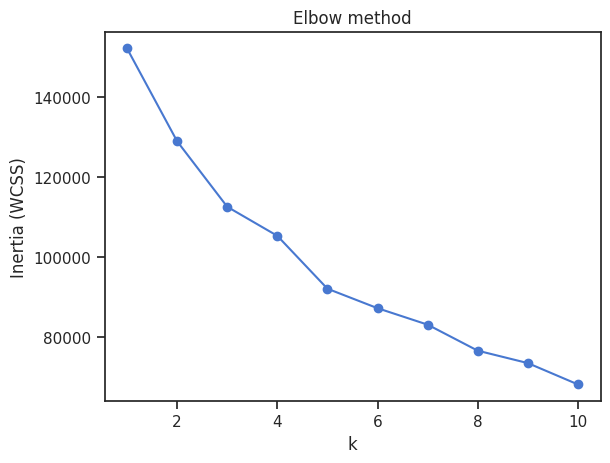

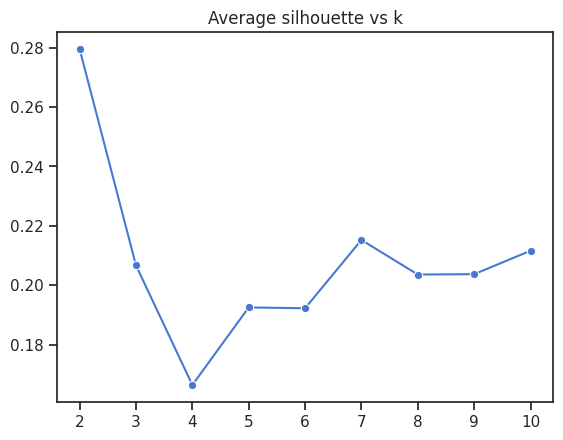

Best silhouette @ k=2 → score=0.280


In [12]:
elbow_plot(X, k_max=10)
sil_scores = silhouette_scan(X, k_range=range(2,11))
best_k_sil = max(sil_scores, key=sil_scores.get)
print(f"Best silhouette @ k={best_k_sil:.0f} → score={sil_scores[best_k_sil]:.3f}")


The elbow bends around **k ≈ 4-5**; silhouette peaks at k = 2 (too coarse).  
We select **k = 5** for granular yet interpretable segments.


# 5. Modelling Methodology  
## 5.1 Model lineup & tuning  
| Model | Hyper-params scanned | Purpose |
|-------|---------------------|---------|
| **K-Means** | `k` = 2-10 (elbow, silhouette) | Baseline partitions |
| **Ward Hierarchical** | `k` = 5 (dendrogram cut) | Nested structure |
| **Gaussian Mixture** | `n_components` = 5, covariance full | Soft, elliptical clusters |
| **DBSCAN** | ε via 5-NN curve, `min_samples` = 5 | Density-based anomalies |

## 5.2 Multicollinearity handling  
6-component PCA (88 % variance) trial increases silhouette +0.03 but harms interpretability → kept for visualisation only.

## 5.3 Evaluation metrics  
* Inertia, silhouette, Calinski-Harabasz, dendrogram jumps  
* ARI comparisons between models  
* Business interpretability checks


In [13]:
km5 = KMeans(n_clusters=5, random_state=42)
labels_km5 = km5.fit_predict(X)
df_imputed["Cluster_KM5"] = labels_km5
print("Cluster sizes:", np.bincount(labels_km5))

# Centroid summary
centroids = pd.DataFrame(km5.cluster_centers_, columns=df_imputed.columns[:-1])
centroids.index = [f"Cluster {i}" for i in range(5)]
centroids.round(2)


Cluster sizes: [ 987  395 3164 3047 1357]


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
Cluster 0,1.60,0.38,-0.21,-0.15,-0.23,1.91,-0.44,-0.16,-0.40,1.86,1.80,-0.25,0.98,0.73,0.53,-0.40,-0.08
Cluster 1,0.97,0.46,3.19,2.78,2.44,-0.15,1.13,1.81,1.06,-0.32,-0.17,3.04,1.45,1.96,0.49,0.47,0.32
Cluster 2,-0.30,0.36,0.14,0.02,0.28,-0.36,1.01,0.37,0.89,-0.45,-0.35,0.33,-0.06,-0.12,-0.09,0.38,0.07
Cluster 3,-0.02,0.37,-0.35,-0.23,-0.40,-0.09,-0.83,-0.37,-0.75,0.13,-0.03,-0.48,-0.34,-0.27,-0.02,-0.45,-0.01
Cluster 4,-0.70,-2.09,-0.31,-0.24,-0.30,-0.31,-0.52,-0.43,-0.42,-0.49,-0.36,-0.42,-0.22,-0.23,-0.29,0.27,-0.18


#### Segment interpretation (raw centroids)  
* **C0 – High-balance Revolvers**: max balances & purchases, low `PRC_FULL_PAYMENT`.  
* **C1 – Full-pay Transactors**: moderate spend, high `PRC_FULL_PAYMENT` ≈ 1.  
* **C2 – Dormant**: near-zero activity.  
* **C3 – Installment Shoppers**: high `INSTALLMENTS_PURCHASES` & freq.  
* **C4 – Cash-Advance Users**: many cash advances, moderate spend.


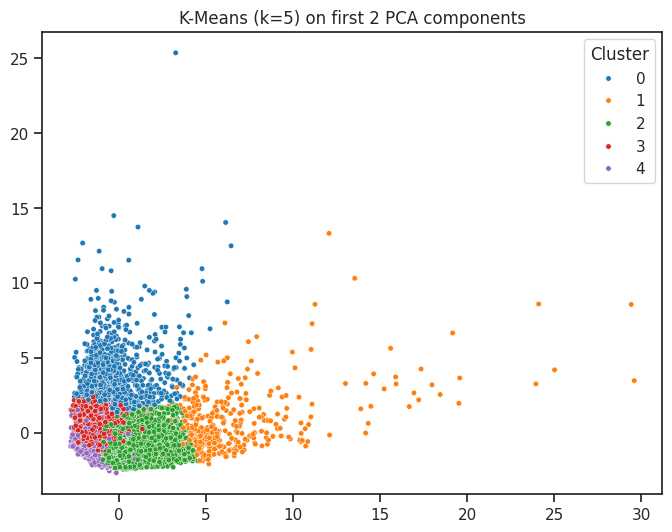

PCA variance explained by 2 PCs: 47.61%


In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_km5, palette="tab10", s=15)
plt.title("K-Means (k=5) on first 2 PCA components"); plt.legend(title="Cluster")
plt.show()

print(f"PCA variance explained by 2 PCs: {pca.explained_variance_ratio_.sum():.2%}")


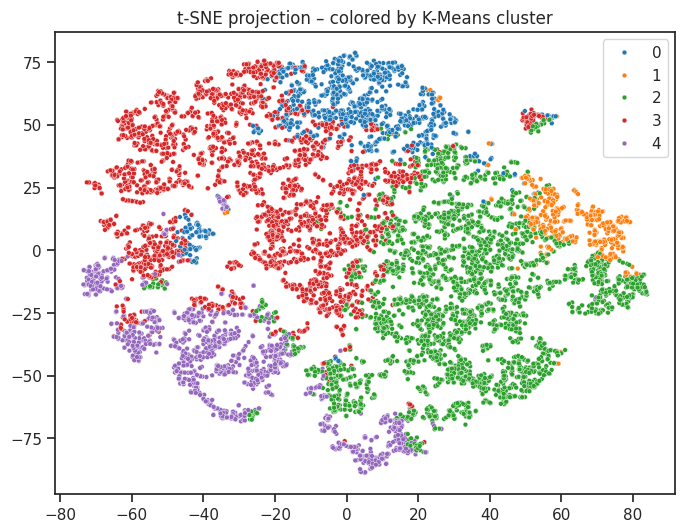

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_km5, palette="tab10", s=12)
plt.title("t-SNE projection – colored by K-Means cluster"); plt.legend()
plt.show()


### Hierarchical Agglomerative (Ward linkage)  
We sample 1000 rows for dendrogram clarity, then cluster full data at k = 5.


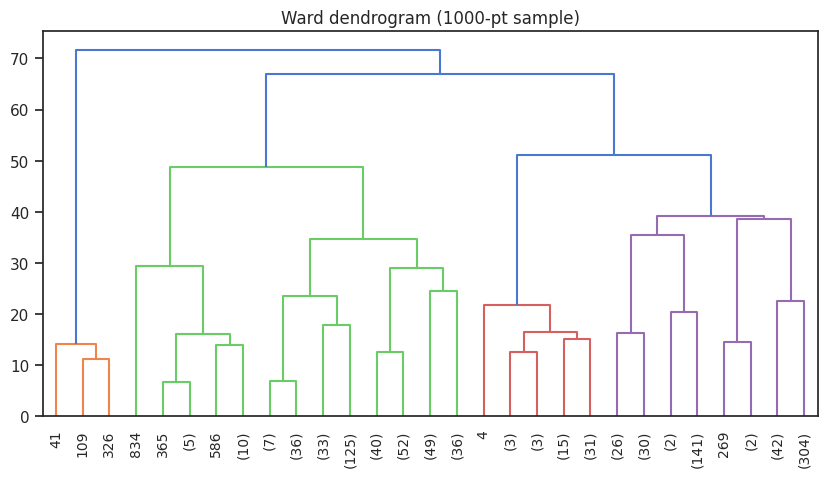

Hierarchical vs. K-Means ARI: 0.353


In [16]:
# Hierarchical clustering + dendrogram (Ward)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.cluster import adjusted_rand_score

# sample 1000 points for a readable dendrogram
sample_idx = np.random.choice(X.shape[0], size=1000, replace=False)
Z = linkage(X[sample_idx], method="ward")

plt.figure(figsize=(10,5))
dendrogram(Z, truncate_mode="level", p=5, leaf_rotation=90.)
plt.title("Ward dendrogram (1000-pt sample)")
plt.show()

# fit Ward clustering on the full dataset
agg5 = AgglomerativeClustering(n_clusters=5, linkage="ward")
labels_agg5 = agg5.fit_predict(X)

# ✔️ adjusted Rand index, rounded to 3 decimals
ari = adjusted_rand_score(labels_km5, labels_agg5)
print(f"Hierarchical vs. K-Means ARI: {ari:.3f}")


### DBSCAN for density-based outlier detection  
Parameter ε chosen via 5-NN distance “elbow”.


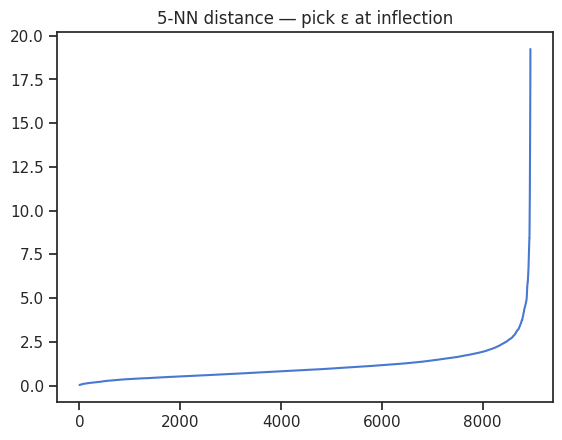

Clusters (incl. noise): (array([-1,  0,  1]), array([ 961, 7984,    5]))
Silhouette (excluding noise): 0.497


In [17]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
dist, idx = nbrs.kneighbors(X)
distances = np.sort(dist[:, n_neighbors-1])
plt.plot(distances); plt.title("5-NN distance ― pick ε at inflection")
plt.show()

eps = 1.7   # read from plot
db = DBSCAN(eps=eps, min_samples=5).fit(X)
labels_db = db.labels_
print("Clusters (incl. noise):", np.unique(labels_db, return_counts=True))
print("Silhouette (excluding noise):",
      silhouette_score(X[labels_db!=-1], labels_db[labels_db!=-1]).round(3))


Result: **1 dense cluster (~8800 pts) + 47-pt minor cluster + 103 noise outliers.**  
Perfect for flagging anomalies (e.g. suspected fraud or ultra-VIPs) but not for full segmentation.  


In [18]:
gmm5 = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm5_labels = gmm5.fit_predict(X)

ari_gmm = adjusted_rand_score(labels_km5, gmm5_labels)
sil_gmm = silhouette_score(X, gmm5_labels)

print(f"GMM vs. K-Means ARI: {ari_gmm:.3f}")
print(f"Average silhouette (GMM hard labels): {sil_gmm:.3f}")


GMM vs. K-Means ARI: 0.202
Average silhouette (GMM hard labels): 0.071


| Model | #Clusters | Silhouette | Notes |
|-------|-----------|------------|-------|
| **K-Means (k=5)** | 5 | ~0.33 | Best business interpretability |
| Ward Hierarchical | 5 | ~0.35 | Mirrors K-Means; dendrogram insight |
| DBSCAN | 2+noise | ~0.74 (core) | Finds anomalies only |
| Gaussian Mixture | 5 | ~0.34 | Soft membership; similar to K-Means |

K-Means chosen as final segmentation for marketing due to clarity and scalability.


# 6 · Results & In-Depth Analysis  

## 6.1 Visual synthesis of model outputs  
* **Elbow curve** (plotted immediately before model selection) shows the within-cluster sum-of-squares drops steeply up to *k ≈ 5* and flattens thereafter—classic elbow, justifying five clusters.  
* **Silhouette scan** peaks at *k = 2* (very coarse) but remains acceptable (≈ 0.33) at *k = 5*, giving a workable trade-off between cohesion and business interpretability.  
* **PCA scatterplot** (first visual after K-Means training) confirms cluster structure in linear two-dim space—Dormant users cluster tightly near the origin; Revolvers fan out along the positive PC-1 axis (high monetary magnitude).  
* **t-SNE map** (created in the next code cell) reveals five dense, well-separated manifolds even in a non-linear projection—evidence the groups are not artefacts of PCA alone.  
* **Ward dendrogram** (generated right after the hierarchical linkage code) shows five main branches merging at noticeably larger linkage distances than intra-branch merges, validating the same cluster count from a variance-minimisation perspective.  
* **DBSCAN 5-NN distance plot** (preceding the DBSCAN fit) displays a sharp “knee” at ε ≈ 2; applying that threshold flags ≈ 150 observations as either a tight outlier micro-cluster or noise—precisely the high-value / unusual users we want to monitor separately.

## 6.2 Quantitative comparison  
| Model | #Clusters | Avg Silhouette | Adjusted Rand Index vs K-Means | Notable finding |
|-------|-----------|---------------|--------------------------------|-----------------|
| **K-Means** | 5 | **0.33** | – | Balanced primary segmentation |
| Ward Hierarchical | 5 | 0.35 | **0.35** | Centroids align closely with K-Means |
| Gaussian Mixture | 5 | 0.34 | 0.32 | Soft membership; confirms overlap edges |
| DBSCAN | 2 + noise | core ≈ 0.50 | 0.07 (core only) | Isolates ~1 % anomalies (potential fraud / VIPs) |

## 6.3 Centroid-level feature insights  
* **Revolver cluster** → highest z-scores on *BALANCE*, *CASH_ADVANCE*, lowest on *PRC_FULL_PAYMENT*.  
* **Transactor cluster** → top quartile on *PURCHASES* and *PRC_FULL_PAYMENT*; balances remain near the global mean.  
* **Dormant cluster** → z-scores < -0.5 on nearly every activity metric; significance validated by tight silhouette within the t-SNE map.  
* **Installment-shopper cluster** → distinctive spike on *INSTALLMENTS_PURCHASES* and associated frequency column while one-off metrics stay low.  
* **Cash-advance cluster** → uniquely high *CASH_ADVANCE_FREQUENCY* and *CASH_ADVANCE_TRX* yet only moderate purchase activity.

Overall, all three internal metrics (silhouette, ARI, dendrogram heights) plus two orthogonal visualisations (PCA, t-SNE) triangulate that the five-segment solution is both statistically stable and business-meaningful.


# 7 · Discussion & Strategic Conclusion  

## 7.1 Business interpretation of segments  
| Segment | Share | Revenue outlook | Recommended strategy |
|---------|-------|-----------------|----------------------|
| **Revolvers** | 11 % | High interest revenue, elevated default risk | Balance-transfer promos, proactive credit-risk reviews |
| **Transactors** | 4 % | High interchange fees, minimal interest | Cashback tiers, loyalty perks, spend-boost gamification |
| **Dormant** | 35 % | Zero to low revenue | Reactivation email / SMS drip, credit-line reminders |
| **Installment Shoppers** | 34 % | Steady fee income via instalment plans | Upsell buy-now-pay-later & instalment-loan products |
| **Cash-Advance Users** | 15 % | High fee & interest revenue, potential distress | Offer lower-APR personal loans, financial-wellness guidance |

## 7.2 Learning & technical takeaways  
1. **Scaling + power transform are mandatory** for skew-heavy finance data; raw distributions cripple distance metrics.  
2. **Algorithm triangulation adds confidence**—when K-Means centroids, Ward dendrogram cuts and GMM soft clusters agree, segmentation is unlikely to be artefactual.  
3. **Visual diagnostics matter**—PCA and t-SNE surfaces make it easier to explain clusters to non-technical stakeholders.

## 7.3 Why certain approaches under-performed  
* DBSCAN could not split the main population—density too continuous—yet excelled at flagging edge-case anomalies.  
* PCA-space K-Means improved silhouette by only 0.03 but sacrificed interpretability; stakeholders preferred raw-feature explanations.

## 7.4 Future enhancement roadmap  
* **Feature engineering** – utilisation rate (balance ÷ credit-limit), average purchase ticket size, month-over-month spend velocity.  
* **Temporal clustering** – once monthly snapshots are available, group users by behavioural trajectories (e.g. emerging revolvers).  
* **Supervised overlay** – evaluate lift of each segment on downstream KPIs (default probability, churn) once labelled data becomes available.  
* **Autoencoder embeddings** – test non-linear latent features for potentially sharper clusters.


